# SD212: Graph mining
## Lab 1: Graph structure

In this lab, you will check three structural properties of real graphs:
* the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions) of degrees,
* the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* the tendency to [cluster](https://en.wikipedia.org/wiki/Clustering_coefficient).

## Import

In [124]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [125]:
from sknetwork.data import load_netset, erdos_renyi
from sknetwork.path import get_distances, get_diameter, get_shortest_path
from sknetwork.utils import bipartite2undirected, get_degrees
from sknetwork.topology import Triangles

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)
* Cinema (bipartite graph)

In [126]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [127]:
type(openflights)

sknetwork.utils.Bunch

In [128]:
# weighted adjacency matrix
adjacency = openflights.adjacency

In [129]:
# binary adjacency matrix
adjacency = adjacency > 0

In [130]:
adjacency

<3097x3097 sparse matrix of type '<class 'numpy.bool_'>'
	with 36386 stored elements in Compressed Sparse Row format>

In [131]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [132]:
cinema = load_netset('cinema')

Parsing files...
Done.


In [133]:
cinema

{'meta': {'name': 'cinema',
  'source': 'https://yago-knowledge.org',
  'description': 'Graph between movies and actors.'},
 'biadjacency': <88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
 	with 304006 stored elements in Compressed Sparse Row format>,
 'names_col': array(['Joe E. Brown', 'Eric Blore', 'Susan Hayward', ...,
        'Olivier Saladin', 'Reona Hirota', 'Leyla Sayar'], dtype='<U95'),
 'names_row': array(['$1,000 a Touchdown', '$9.99', '$', ...,
        'Šta se zgodi kad se ljubav rodi', 'Želary', '’O Re'], dtype='<U95')}

## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* in-degrees and out-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale.
* Conclude: do you consider that these are power-law graphs?

In [134]:
def plot_loglog(degrees):
    """Plot the degree distribution in log-log scale and compare with that of a random graph.
    
    Parameters
    ----------
    degrees : array
        vector of degrees of the graph.
    """
    n = len(degrees)
    # comparison with a random graph
    adjacency_random = erdos_renyi(n, np.sum(degrees) / n / (n-1))
    degrees_random = adjacency_random.dot(np.ones(n))
    plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3, label='Real graph')
    plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n, lw = 3, label = 'Random graph')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

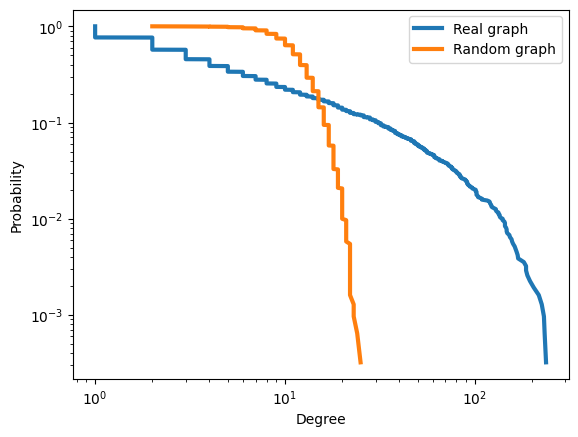

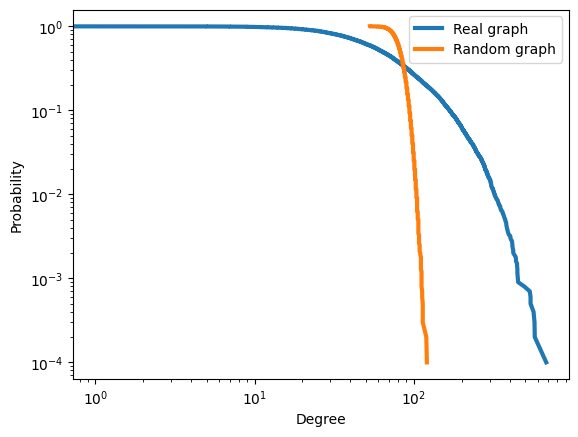

In [135]:
degrees = adjacency.dot(np.ones(adjacency.shape[0]))
plot_loglog(degrees)

degrees = get_degrees(wikivitals.adjacency)
plot_loglog(degrees)


## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Give a shortest path of maximum length starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
List the corresponding airports.
* Give a shortest path from [Plato](https://en.wikipedia.org/wiki/Plato) to [Platini](https://en.wikipedia.org/wiki/Michel_Platini) in WikiVitals.<br>
List the corresponding articles.

In [171]:
names = openflights.names

cdg = np.where(names == "Charles de Gaulle International Airport")[0][0]
print("CDG index:", cdg)

# Give a shortest path of maximum length starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
# List the corresponding airports.

pathsFromCdg = get_shortest_path(adjacency, cdg, np.where(names != "Charles de Gaulle International Airport")[0])

distances = get_distances(adjacency, sources=cdg)
farthestAirport = np.where(distances == np.max(distances))
print("Farthest airport from CDG:", names[farthestAirport[0][0]])

print("Number of airports:", distances[farthestAirport[0][0]])

maxPath = get_shortest_path(adjacency, cdg, farthestAirport[0][0])
print("Indexes of airports:", maxPath)
print("Listing the airport")
for i in range(len(maxPath)):
    print(i, names[maxPath[i]])


CDG index: 622
Farthest airport from CDG: Peawanuck Airport
Number of airports: 7.0
Indexes of airports: [622, 124, 85, 56, 2253, 2290, 2248, 2277]
Listing the airport
0 Charles de Gaulle International Airport
1 Lester B. Pearson International Airport
2 Timmins/Victor M. Power
3 Moosonee Airport
4 Fort Albany Airport
5 Kashechewan Airport
6 Attawapiskat Airport
7 Peawanuck Airport


In [172]:
names = wikivitals.names

plato = np.where(names == "Plato")[0][0]
platini = np.where(names == "Michel Platini")[0][0]
print("Plato index:", plato)
print("Platini index:", platini)
minLength = np.inf

pathPlatoToPlatini = get_shortest_path(wikivitals.adjacency, plato, platini)

print("Number of pages:", len(pathPlatoToPlatini))
print("Indexes of pages:", pathPlatoToPlatini)
print("Listing the pages")
for i in range(len(pathPlatoToPlatini)):
    print(i, names[pathPlatoToPlatini[i]])

Plato index: 7108
Platini index: 5893
Number of pages: 4
Indexes of pages: [7108, 6247, 2390, 5893]
Listing the pages
0 Plato
1 Naples
2 Diego Maradona
3 Michel Platini


## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [177]:
# Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
n = len(openflights.names)
print("Number of airports:", n)
distances = get_distances(adjacency, sources=cdg)

print("In 1 flight:", 100*(len(np.where(distances == 1)[0]))/n, "%")
print("In 2 flights:", 100*(len(np.where(distances == 2)[0]))/n, "%")
print("In 3 flights:", 100*(len(np.where(distances == 3)[0]))/n, "%")

# Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

distances = get_distances(wikivitals.adjacency, sources=np.where(names == "Paris")[0][0])
n = len(wikivitals.names)
print("Number of pages:", n)

print("In 1 click:", 100*(len(np.where(distances == 1)[0]))/n, "%")
print("In 2 clicks:", 100*(len(np.where(distances == 2)[0]))/n, "%")
print("In 3 clicks:", 100*(len(np.where(distances == 3)[0]))/n, "%")

Number of airports: 3097
In 1 flight: 7.523409751372296 %
In 2 flights: 54.34291249596384 %
In 3 flights: 28.995802389409107 %
Number of pages: 10011
In 1 click: 3.945659774248327 %
In 2 clicks: 63.46019378683448 %
In 3 clicks: 31.914893617021278 %


## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.

Bacon index: 3465
Number of actors: 133026


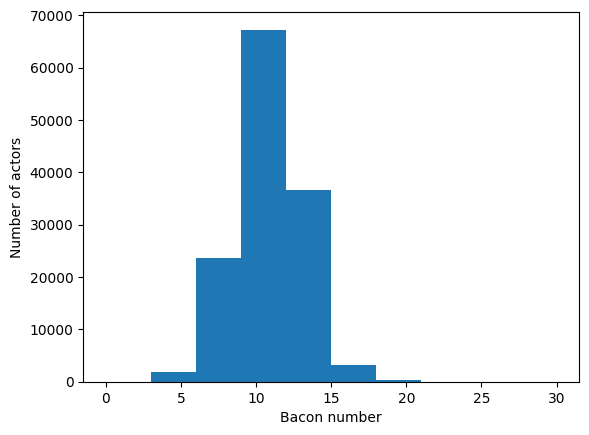

In [183]:
# Compute the bacon number of all actors (**without** building the co-starring actor graph).

adjacencyCinema = bipartite2undirected(cinema.biadjacency)
namesCinema = cinema.names_col

bacon = np.where(namesCinema == "Kevin Bacon")[0][0]
print("Bacon index:", bacon)
baconNumber = get_distances(adjacencyCinema, bacon)

print("Number of actors:", len(baconNumber))

# Plot the corresponding histogram.

plt.hist(baconNumber, bins=10)
plt.xlabel("Bacon number")
plt.ylabel("Number of actors")
plt.show()

## 3. Clustering coefficient

Finally, we check the clustering property of real graph (my friends tend to be friends).

## To do


* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).
* Compare with that of a random graph of same size.

In [159]:
# Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).

triangles = Triangles()
triangles.fit(openflights.adjacency)
print("Openflights clustering coefficient:", triangles.clustering_coef_)

triangles = Triangles()
triangles.fit(wikivitals.adjacency)
print("WikiVitals clustering coefficient:", triangles.clustering_coef_)

# Compare with that of a random graph of same size.
n = len(openflights.names)
adjacency_random = erdos_renyi(n, np.sum(degrees) / n / (n-1))
triangles = Triangles()
triangles.fit(adjacency_random)
print("Random graph clustering coefficient:", triangles.clustering_coef_)

Openflights clustering coefficient: 0.25107219520077
WikiVitals clustering coefficient: 0.21128544972101573
Random graph clustering coefficient: 0.08608473933687065
